This notebook will examine the GEM model wind direction and speed by compareing a time series with observations. I will examine 
1. Sandheads - http://climate.weather.gc.ca/climateData/hourlydata_e.html?timeframe=1&Prov=BC%20%20&StationID=6831&hlyRange=1994-02-01|2014-09-23&Year=2014&Month=9&Day=21
2. Entance Island - http://climate.weather.gc.ca/climateData/hourlydata_e.html?timeframe=1&Prov=BC%20%20&StationID=29411&hlyRange=1994-02-01|2014-10-01&Year=2014&Month=10&Day=1
3. Pam Rocks - http://climate.weather.gc.ca/climateData/hourlydata_e.html?timeframe=1&Prov=BC%20%20&StationID=6817&hlyRange=1994-02-01|2014-10-01&Year=2014&Month=10&Day=1
4. YVR - http://climate.weather.gc.ca/climateData/hourlydata_e.html?timeframe=1&Prov=BC&StationID=51442&hlyRange=2013-06-11|2014-10-05&Year=2014&Month=10&Day=5
5. Sisters Islands - http://climate.weather.gc.ca/climateData/hourlydata_e.html?timeframe=1&Prov=&StationID=6813&hlyRange=1994-02-01|2014-10-01&Year=2014&Month=10&Day=1
6. Esquimalt - http://climate.weather.gc.ca/climateData/hourlydata_e.html?timeframe=1&Prov=&StationID=52&hlyRange=1994-02-01|2014-10-01&Year=2014&Month=10&Day=1
5. NOAA Buoy - http://www.ndbc.noaa.gov/station_page.php?station=46041

In [1]:
from __future__ import division

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
import pytz, datetime
import glob
import os
import urllib2
import csv
import cStringIO
import requests
from xml.etree import cElementTree as ElementTree
import pandas as pd
import arrow
from matplotlib import dates


%matplotlib inline




In [2]:
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
NEMOlat=grid.variables['nav_lat'][:]
NEMOlon=grid.variables['nav_lon'][:]
bathy=grid.variables['Bathymetry'][:]

In [3]:
GEM = nc.Dataset('/ocean/dlatorne/MEOPAR/GEM2.5/NEMO-atmos/res_y2015m08d06.nc')
GEMlon = GEM.variables['nav_lon'][:]-360
GEMlat = GEM.variables['nav_lat'][:]

nc_tools.show_variable_attrs(GEM)

<type 'netCDF4._netCDF4.Variable'>
float32 nav_lat(y, x)
    units: degrees_north
    valid_min: -90.0
    valid_max: 90.0
    long_name: Latitude
    nav_model: Default grid
unlimited dimensions: 
current shape = (300, 360)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4._netCDF4.Variable'>
float32 nav_lon(y, x)
    units: degrees_east
    valid_min: 0.0
    valid_max: 360.0
    long_name: Longitude
    nav_model: Default grid
unlimited dimensions: 
current shape = (300, 360)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4._netCDF4.Variable'>
float32 precip(time_counter, y, x)
    units: m
    missing_value: 1e+20
    valid_min: 0.0
    valid_max: 10.0
    long_name: total precipitation
    short_name: precip
    online_operation: inst(only(x))
    axis: TYX
    scale_factor: 1.0
    add_offset: 0.0
    savelog10: 0.0
unlimited dimensions: time_counter
current shape = (24, 300, 360)
filling on, default _FillValue of 9.96920996839e+36 u

In [4]:
OP = nc.Dataset('/ocean/sallen/allen/research/Meopar/Operational/ops_y2014m11d18.nc')
OPlon =OP.variables['nav_lon'][:]-360
OPlat = OP.variables['nav_lat'][:]
nc_tools.show_variables(OP)

nc_tools.show_variable_attrs(OP)

[u'atmpres', u'nav_lat', u'nav_lon', u'precip', u'qair', u'solar', u'tair', u'therm_rad', u'time_counter', u'u_wind', u'v_wind', u'x', u'y']
<type 'netCDF4._netCDF4.Variable'>
float32 atmpres(time_counter, y, x)
    _FillValue: 9.999e+20
    short_name: PRMSL_meansealevel
    long_name: Pressure Reduced to MSL
    level: mean sea level
    units: Pa
    coordinates: longitude latitude
unlimited dimensions: time_counter
current shape = (24, 266, 256)
filling on
<type 'netCDF4._netCDF4.Variable'>
float64 nav_lat(y, x)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (266, 256)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4._netCDF4.Variable'>
float64 nav_lon(y, x)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (266, 256)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4._netCDF4.Variable'>
float32 precip(time_counter, y, x)
    _FillValue: 9.999e+20
    short_n

# Transforming observed wind direction

Meteoroligists define wind direction as the direction from which the wind is coming, measured on a compass (0 degrees = coming from the North). 

Modellers define direction as the direction that the current is travelling towards, measured on a cartesian grid (0 degrees = going towards the East).

$\theta_{met} \rightarrow \theta_{model}\\
0 \rightarrow 270 \\
90 \rightarrow 180 \\
180 \rightarrow 90 \\
270 \rightarrow 0$

So, the positive direction for $\theta$ on the meterological grid is opposite to the model grid. 

The transformation on $\theta$ between grids is

$\theta_{mod} = -\theta_{met} +270 $

This has been implented in stormtools.get_EC_observations().

# Environment Canada Data

Load data from Environment Canada first.

In [5]:
wind_speed = {}; wind_dir = {}; time = {}; lat={}; lon={}; press={}; temp={}; therm={}; solar={}; precip={}; qair={}


start = '6-Aug-2015'; end = '10-Aug-2015';
start2 = '10-Aug-2015'; end2 = '10-Aug-2015';

stations = ['Sandheads','EntranceIsland', 'PamRocks', 'YVR', 'SistersIsland', 'Esquimalt']

for key in stations:
    [wind_speed[key],wind_dir[key],temp[key],time[key], 
     lat[key], lon[key]] = stormtools.get_EC_observations(key,start,end)
    [ws,wd,T,t, la, lo] = stormtools.get_EC_observations(key,start2,end2)
    wind_speed[key]=np.append(wind_speed[key],ws)
    wind_dir[key]=np.append(wind_dir[key],wd)
    time[key]=np.append(time[key],t)
    temp[key]=np.append(temp[key],T)

In [6]:
def find_model_point(lon,lat,X,Y):
        # Tolerance for searching for grid points
    # (approx. distances between adjacent grid points)
    tol1 = 0.015 # lon
    tol2 = 0.015# lat

    # Search for a grid point with lon/lat within tolerance of
    # measured location
    x1, y1 = np.where(
        np.logical_and(
            (np.logical_and(X > lon-tol1, X < lon+tol1)),
            (np.logical_and(Y > lat-tol2, Y < lat+tol2))))
    return x1[0], y1[0]

# Models

Now, loop through GEM data and Operational model and calculate wind speed and direction
  

In [7]:
to = datetime.datetime(2015,8,6); sstr = to.strftime('res_y%Ym%md%d.nc')
tf = datetime.datetime(2015,8,10);  estr = tf.strftime('res_y%Ym%md%d.nc')

files = glob.glob('/ocean/dlatorne/MEOPAR/GEM2.5/NEMO-atmos/res_*.nc')
filesGEM = []
for filename in files:
    if os.path.basename(filename) >= sstr:
        if os.path.basename(filename) <= estr:
            filesGEM.append(filename)
    filesGEM.sort(key=os.path.basename)
filesGEM.sort(key=os.path.basename)

sstr = to.strftime('ops_y%Ym%md%d.nc')
estr = tf.strftime('ops_y%Ym%md%d.nc')
files = glob.glob('/ocean/sallen/allen/research/Meopar/Operational/ops_*.nc')
filesOP = []
for filename in files:
    if os.path.basename(filename) >= sstr:
        if os.path.basename(filename) <= estr:
            filesOP.append(filename)
    filesOP.sort(key=os.path.basename)
filesOP.sort(key=os.path.basename)

#Remove bad dates from GEM files.
#In May 2015, bad dates are May 4 and May 16
#filesGEM.remove('/ocean/dlatorne/MEOPAR/GEM2.5/NEMO-atmos/res_y2015m05d04.nc')
#filesGEM.remove('/ocean/dlatorne/MEOPAR/GEM2.5/NEMO-atmos/res_y2015m05d16.nc')

In [8]:
def compile_GEM(j,i):
    wind=[]; direc=[]; t=[]; pr=[]; sol=[]; the=[]; pre=[]; tem=[]; qr=[];
    for f in filesGEM:
        G = nc.Dataset(f)
        u = G.variables['u_wind'][0:24,j,i]; v=G.variables['v_wind'][0:24,j,i];
        pr.append(G.variables['seapres'][0:24,j,i]); sol.append(G.variables['solar'][0:24,j,i]); 
        #new GEM files are seapres instead of atmpres
        qr.append(G.variables['qair'][0:24,j,i]); the.append(G.variables['therm_rad'][0:24,j,i]); 
        pre.append(G.variables['precip'][0:24,j,i]);
        tem.append(G.variables['tair'][0:24,j,i])
        speed = np.sqrt(u**2 + v**2)
        wind.append(speed)
        
        d = np.arctan2(v, u)
        d = np.rad2deg(d + (d<0)*2*np.pi);
        direc.append(d)
        
        ts=G.variables['time_counter']
        torig = (nc_tools.time_origin(G)).datetime
        for ind in np.arange(24):
            t.append(torig + datetime.timedelta(seconds=int(ts[ind])))
            
        
    wind = np.array(wind).reshape(len(filesGEM)*24,)
    direc = np.array(direc,'double').reshape(len(filesGEM)*24,)
    t = np.array(t).reshape(len(filesGEM)*24,)
    pr = np.array(pr).reshape(len(filesGEM)*24,)
    tem = np.array(tem).reshape(len(filesGEM)*24,)
    sol = np.array(sol).reshape(len(filesGEM)*24,)
    the = np.array(the).reshape(len(filesGEM)*24,)
    qr = np.array(qr).reshape(len(filesGEM)*24,)
    pre = np.array(pre).reshape(len(filesGEM)*24,)
    
    return wind, direc, t, pr, tem, sol, the, qr, pre

In [9]:
def compile_OP(j,i):
    wind=[]; direc=[]; t=[]; pr=[]; sol=[]; the=[]; pre=[]; tem=[]; qr=[];
    for f in filesOP:
        G = nc.Dataset(f)
        u = G.variables['u_wind'][0:24,j,i]; v=G.variables['v_wind'][0:24,j,i];
        pr.append(G.variables['atmpres'][0:24,j,i]); sol.append(G.variables['solar'][0:24,j,i]); 
        qr.append(G.variables['qair'][0:24,j,i]); the.append(G.variables['therm_rad'][0:24,j,i]); 
        pre.append(G.variables['precip'][0:24,j,i]); tem.append(G.variables['tair'][0:24,j,i])
        speed = np.sqrt(u**2 + v**2)
        wind.append(speed)
        
        d = np.arctan2(v, u)
        d = np.rad2deg(d + (d<0)*2*np.pi);
        direc.append(d)
        
        ts=G.variables['time_counter']
        torig = datetime.datetime(1970,1,1) #there is no time_origin attriubte in OP files, so I hard coded this
        for ind in np.arange(24):
            t.append(torig + datetime.timedelta(seconds=ts[ind]))
    
    wind = np.array(wind).reshape(len(filesOP)*24,)
    direc = np.array(direc,'double').reshape(len(filesOP)*24,)
    t = np.array(t).reshape(len(filesOP)*24,)
    pr= np.array(pr).reshape(len(filesOP)*24,)
    tem = np.array(tem).reshape(len(filesOP)*24,)
    sol = np.array(sol).reshape(len(filesOP)*24,)
    the = np.array(the).reshape(len(filesOP)*24,)
    qr = np.array(qr).reshape(len(filesOP)*24,)
    pre = np.array(pre).reshape(len(filesOP)*24,)
    
    return wind, direc, t, pr, tem, sol, the, qr, pre

In [10]:
stationsGEM =['Sandheads_GEM', 'EntranceIsland_GEM','PamRocks_GEM','YVR_GEM',
                     'SistersIsland_GEM','Esquimalt_GEM']

stationsOP =['Sandheads_OP', 'EntranceIsland_OP','PamRocks_OP','YVR_OP',
                     'SistersIsland_OP','Esquimalt_OP']

for (obs, modGEM, modOP) in zip(stations,stationsGEM, stationsOP):
    [j,i]=find_model_point(lon[obs],lat[obs],GEMlon,GEMlat)
    lon[modGEM] = GEMlon[j,i]
    lat[modGEM]=GEMlat[j,i]

    [wind_speed[modGEM],wind_dir[modGEM],time[modGEM],
     press[modGEM],temp[modGEM],solar[modGEM],
     therm[modGEM],qair[modGEM],precip[modGEM]] = compile_GEM(j,i)
    
    [j,i]=find_model_point(lon[obs],lat[obs],OPlon,OPlat)
    lon[modOP] = OPlon[j,i]
    lat[modOP]=OPlat[j,i]

    [wind_speed[modOP],wind_dir[modOP],time[modOP],
     press[modOP],temp[modOP],solar[modOP],
     therm[modOP],qair[modOP],precip[modOP]] = compile_OP(j,i)

# Buoy

In [11]:
key='Buoy'
lat[key]=47.353 
lon[key]=-124.731

[j,i]=find_model_point(lon[key],lat[key],GEMlon,GEMlat)
key='Buoy_GEM'
lon[key] = GEMlon[j,i]
lat[key]=GEMlat[j,i]

[wind_speed[key],wind_dir[key],time[key],
 press[key],temp[key],solar[key],
therm[key],qair[key],precip[key]]= compile_GEM(j,i)

[j,i]=find_model_point(lon[key],lat[key],OPlon,OPlat)
key='Buoy_OP'
lon[key] = OPlon[j,i]
lat[key]=OPlat[j,i]

[wind_speed[key],wind_dir[key],time[key],
press[key],temp[key],solar[key],
therm[key],qair[key],precip[key]]= compile_OP(j,i)

Grab data from the NOAA website. Data is saved in Output.txt. This will change over time as the archived data on this website is updated.

Aberdeen Buoy stopped transmissions on Oct 10, 2014.

response = urllib2.urlopen('http://www.ndbc.noaa.gov/data/realtime2/46041.cwind')
html = response.read()
text_file = open("Output.txt", "w")
text_file.write(html)
text_file.close()

Grab 10 m data from NOAA website.  Data is saved in Output_derived.txt. This will change over time as the archived data on this website is updated.

In [12]:
response = urllib2.urlopen('http://www.ndbc.noaa.gov/data/derived2/46041.dmv')
html = response.read()
text_file = open("Output_derived.txt", "w")
text_file.write(html)
text_file.close()

In [13]:
#read in csv
key='Buoy'
fil= csv.reader(open('Output.txt','rb'),delimiter=' ')
fil.next()
fil.next()
time[key]=[]; wind_speed[key]=[]; wind_dir[key]=[]
for row in fil:
    aList=[]
    for element in row:
        if element != '':
            aList.append(element)
    time[key].append(datetime.datetime(int(aList[0]),int(aList[1]),int(aList[2]),int(aList[3]),int(aList[4])))
    d = -float(aList[5])+270
    d=d+ 360 * (d<0)
    wind_dir[key].append(d)
    wind_speed[key].append(float(aList[6]))
time[key]=np.array(time[key])
wind_dir[key]=np.array(wind_dir[key])
wind_speed[key]=np.array(wind_speed[key])
# and the 10 m derived winds
key='Buoy10m'
fil= csv.reader(open('Output_derived.txt','rb'),delimiter=' ')
fil.next()
fil.next()
time[key]=[]; wind_speed[key]=[]; wind_dir[key]=[]
for row in fil:
    aList=[]
    for element in row:
        if element != '':
            aList.append(element)
    time[key].append(datetime.datetime(int(aList[0]),int(aList[1]),int(aList[2]),int(aList[3]),
                                       int(aList[4])))
    wind_speed[key].append(float(aList[9]))
time[key]=np.array(time[key])
wind_speed[key]=np.array(wind_speed[key])

# Plotting

In [14]:
def compare_winds(key1,key2,key3,sax,eax):
    #compare wind speed and direction for data indicated by key1 and key2
    #time limits on axis given by sax,eax
    fig,axs = plt.subplots(2,1,figsize=(20,8))

    for key in [key1,key2,key3]:
        ax=axs[0]
        ax.plot(time[key],wind_speed[key],label=key)
        ax.set_title('Wind speed')
        ax.set_xlim([sax,eax])
        ax.legend(loc=0)
        ax.set_ylabel('wind speed (m/s)')
    
        ax=axs[1]
        ax.plot(time[key],wind_dir[key],label=key)
        ax.set_title('Wind direction')
        ax.set_xlim([sax,eax])
        ax.legend(loc=0)
        ax.set_ylabel('wind direction (degrees CCW from East)')
    
    fig,ax = plt.subplots(1,1,figsize=(5,6))
    for key in [key1,key2,key3]:
        ax.plot(lon[key],lat[key],'o',label=key)
        viz_tools.plot_coastline(ax,grid,coords='map')
        ax.legend(loc=0)
        
    return ax

In [15]:
def compare_other_fields(key1,key2,sax,eax):
    fig,axs = plt.subplots(3,2,figsize=(20,10))
    axs=axs.flatten()
    colors={key1: 'g',key2:'r','obs':'b'}
    
    for key in [key1,key2]:
        ax=axs[0]
        ax.plot(time[key],press[key],colors[key],label=key)
        ax.set_title('Sea level pressure')
        ax.set_xlim([sax,eax]); ax.set_ylim([99000, 103000])
        ax.legend(loc=0);
        ax.set_ylabel('Sea level pressure (Pa)')
        ax.legend(loc=0);
    
        ax=axs[1]
        ax.plot(time[key],temp[key],colors[key],label=key)
        ax.set_title('Temperature 2m above ground')
        ax.set_xlim([sax,eax]); ax.set_ylim([270, 300])
        ax.set_ylabel('Temperature (K)')
        
        ax=axs[2]
        ax.plot(time[key],solar[key],colors[key],label=key)
        ax.set_title('Short wave radiation')
        ax.set_xlim([sax,eax]); ax.set_ylim([0,800])
        ax.legend(loc=0)
        ax.set_ylabel('Short wave radiaiton(W/m^2)')
    
        ax=axs[3]
        ax.plot(time[key],therm[key],colors[key],label=key)
        ax.set_title('Thermal radiation')
        ax.set_xlim([sax,eax]); ax.set_ylim([200, 400])
        ax.legend(loc=0)
        ax.set_ylabel('Thermal radiaiton (W/m^2)')
        
        ax=axs[4]
        ax.plot(time[key],qair[key],colors[key],label=key)
        ax.set_title('Specific Humidty')
        ax.set_xlim([sax,eax]); ax.set_ylim([0, 0.012])
        ax.legend(loc=0)
        ax.set_ylabel('Specfific Humidity (kg/kg)')
    
        ax=axs[5]
        ax.plot(time[key],precip[key],colors[key],label=key)
        ax.set_title('Precipitaion')
        ax.set_xlim([sax,eax]); ax.set_ylim([0, 0.02])
        ax.legend(loc=0)
        ax.set_ylabel('Precipitation (kg/m^2)')
        
    key=key2[:-3]
    if key != 'Buoy':
        axs[1].plot(time[key],temp[key],colors['obs'],label='observations')
        axs[1].legend(loc=0)
        
    return axs

## Sandheads

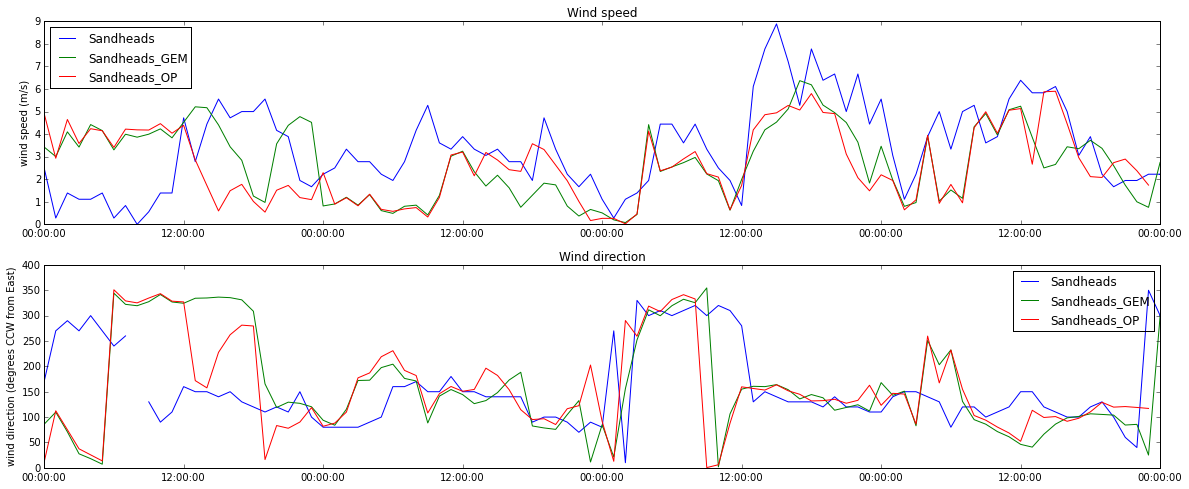

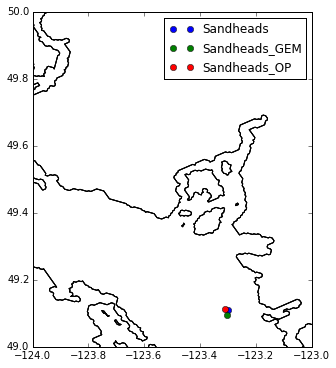

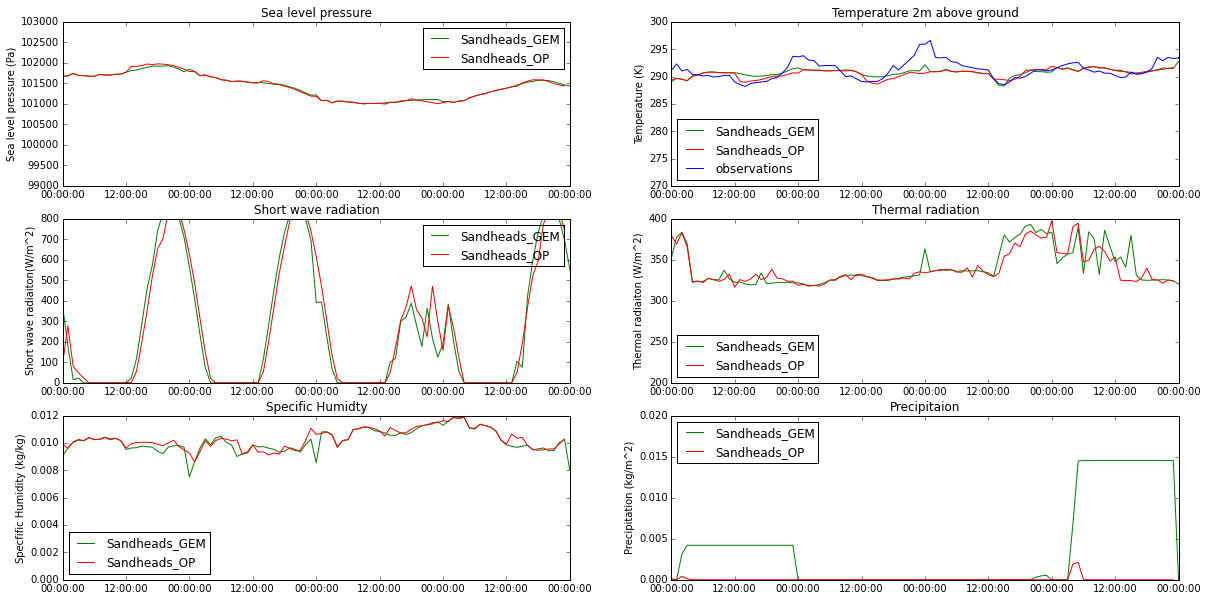

In [16]:
sax=datetime.datetime.strptime(start,'%d-%b-%Y')
eax=datetime.datetime.strptime(end,'%d-%b-%Y')

ax =compare_winds('Sandheads','Sandheads_GEM','Sandheads_OP',sax,eax)
ax.set_xlim([-124,-123])
ax.set_ylim([49,50])
ax =compare_other_fields('Sandheads_GEM','Sandheads_OP',sax,eax)

## Entrance Island

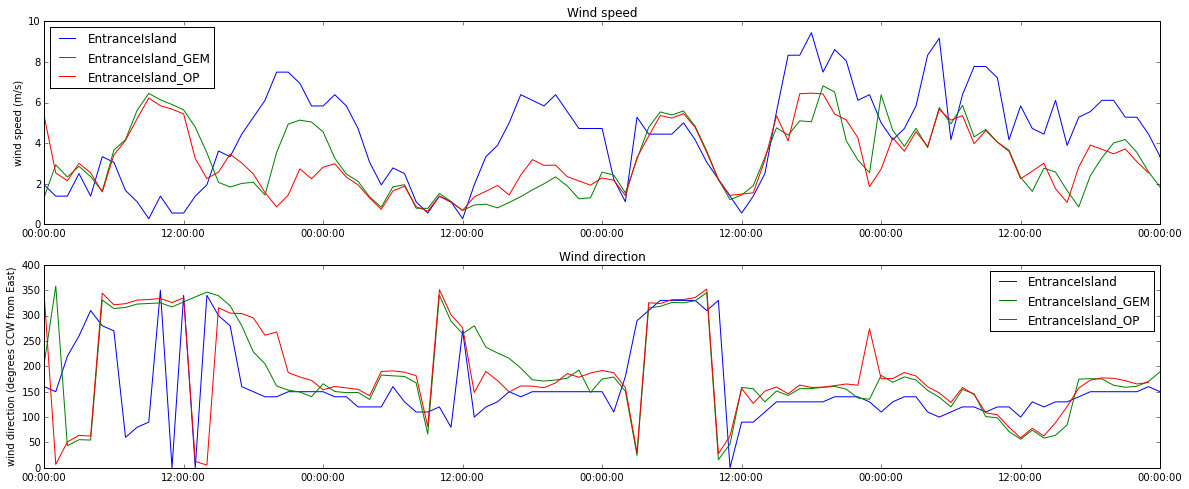

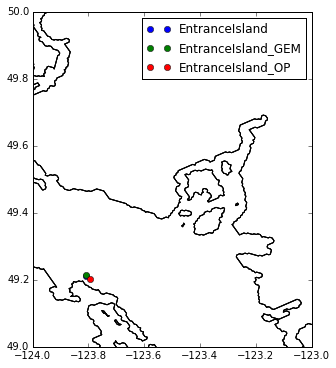

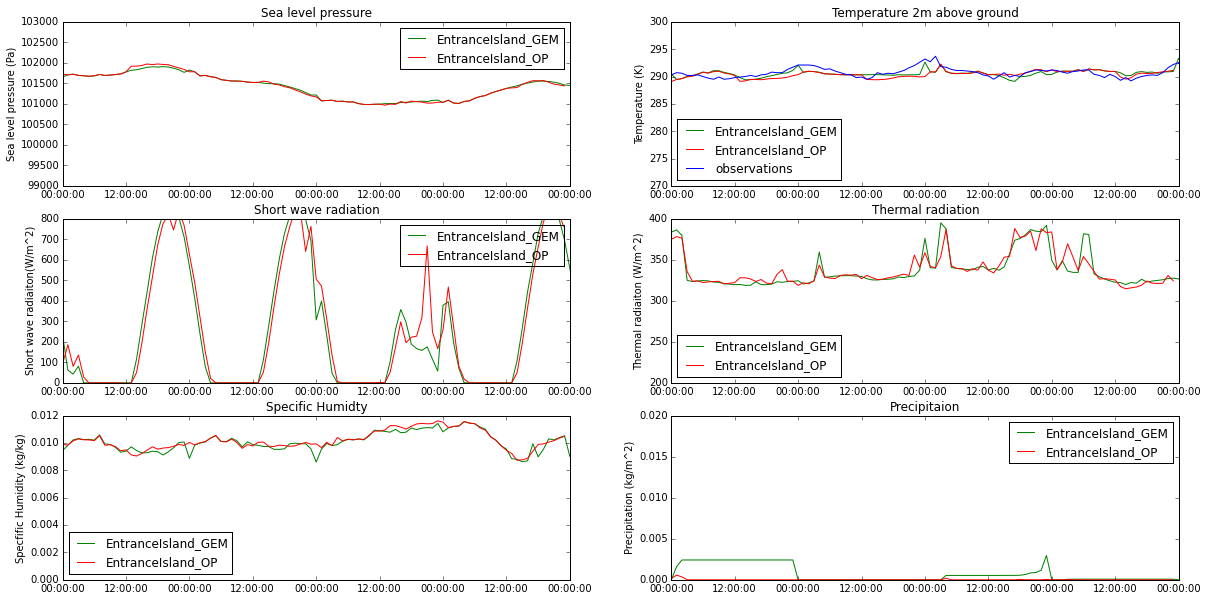

In [17]:

ax=compare_winds('EntranceIsland','EntranceIsland_GEM','EntranceIsland_OP',sax,eax)
ax.set_xlim([-124,-123])
ax.set_ylim([49,50])
ax =compare_other_fields('EntranceIsland_GEM','EntranceIsland_OP',sax,eax)

## Pam Rocks

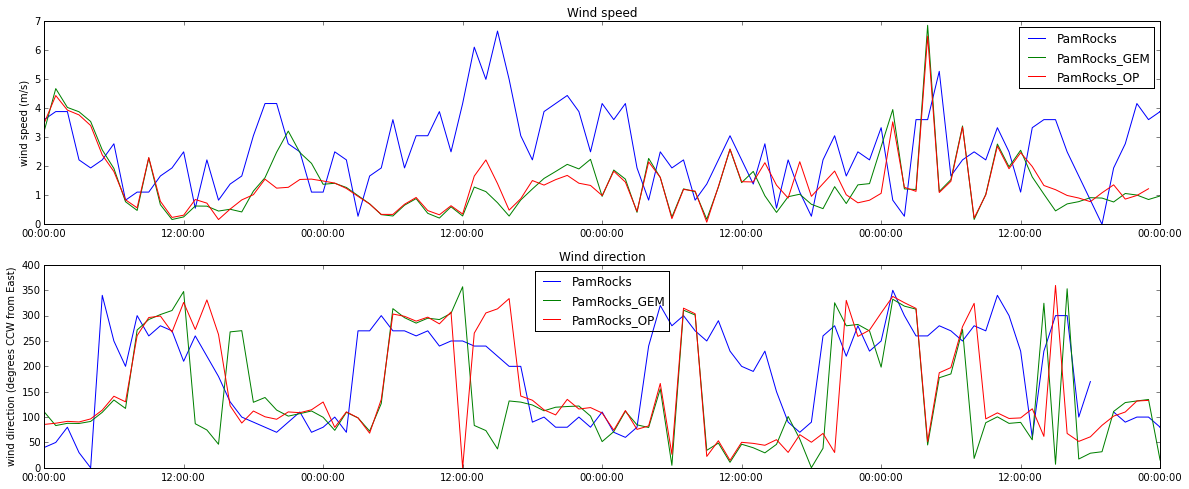

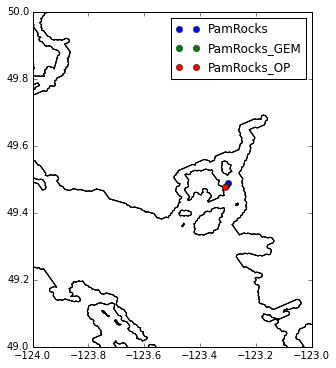

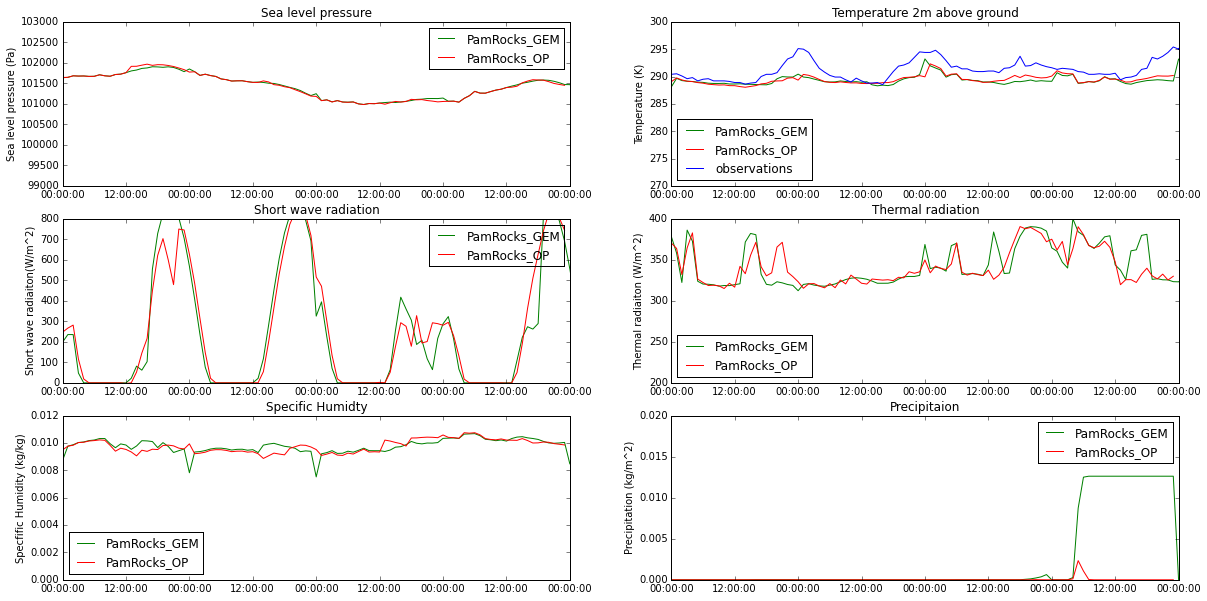

In [18]:
ax=compare_winds('PamRocks','PamRocks_GEM','PamRocks_OP',sax,eax)
ax.set_xlim([-124,-123])
ax.set_ylim([49,50])
ax =compare_other_fields('PamRocks_GEM','PamRocks_OP',sax,eax)

## YVR

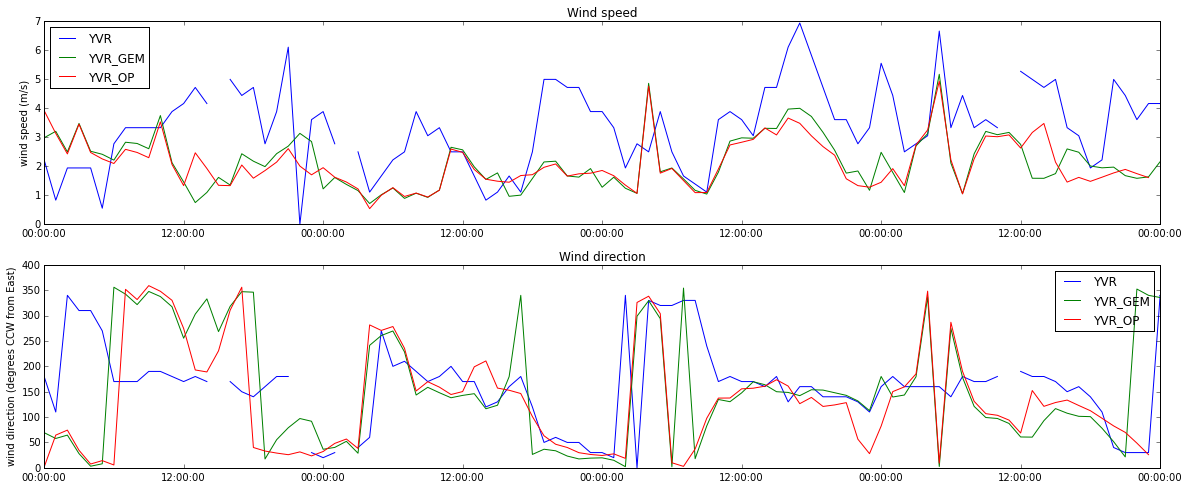

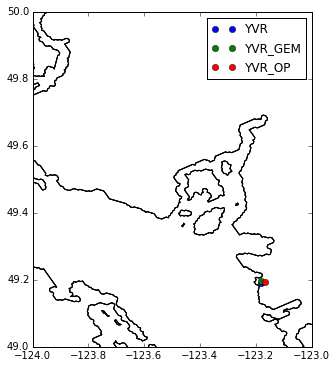

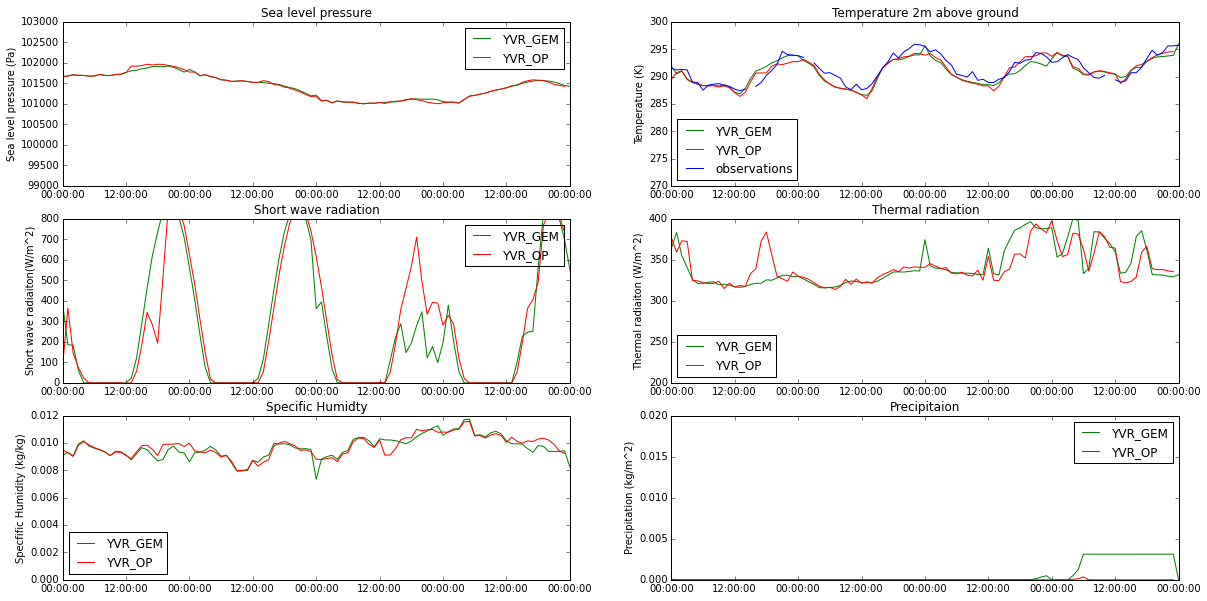

In [19]:
ax=compare_winds('YVR','YVR_GEM','YVR_OP',sax,eax)
ax.set_xlim([-124,-123])
ax.set_ylim([49,50])
ax =compare_other_fields('YVR_GEM','YVR_OP',sax,eax)

## Sisters Island

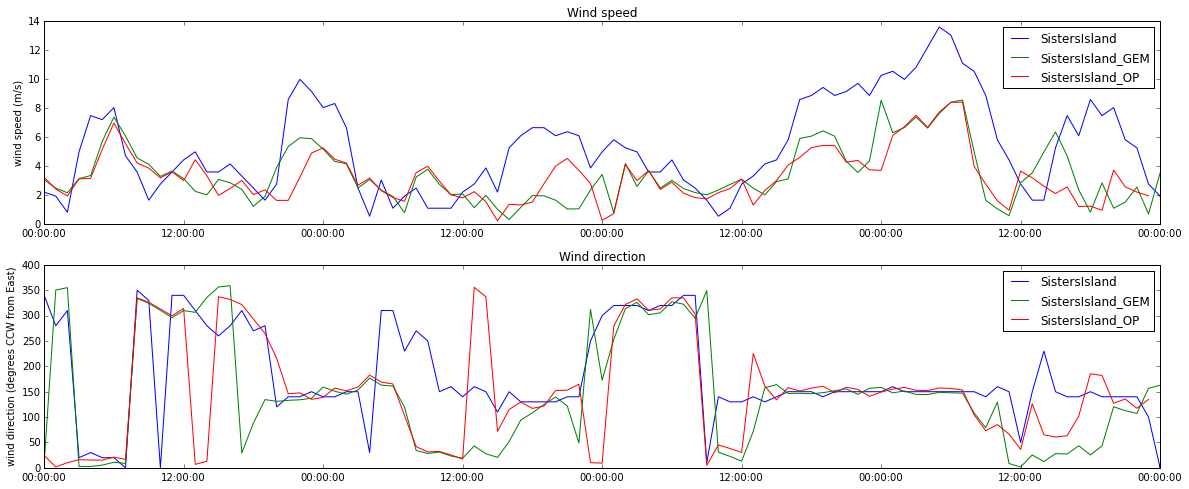

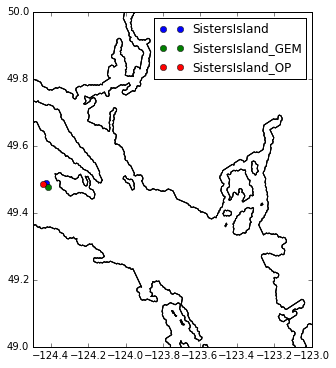

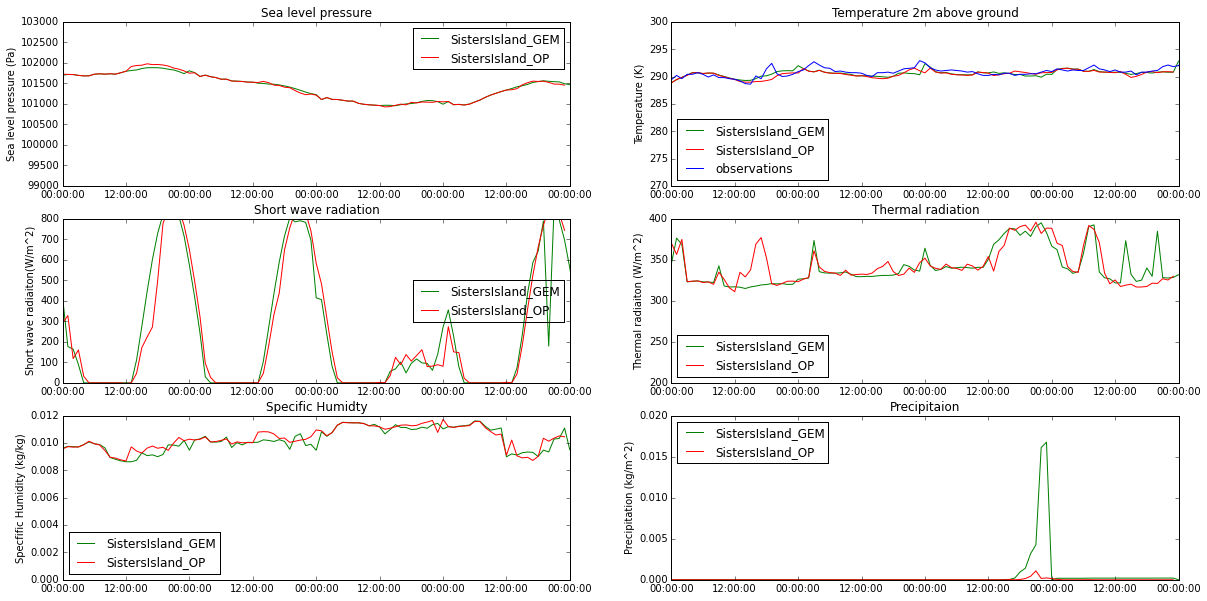

In [20]:
ax=compare_winds('SistersIsland','SistersIsland_GEM','SistersIsland_OP',sax,eax)
ax.set_xlim([-124.5,-123])
ax.set_ylim([49,50])
ax =compare_other_fields('SistersIsland_GEM','SistersIsland_OP',sax,eax)

## Esquimalt

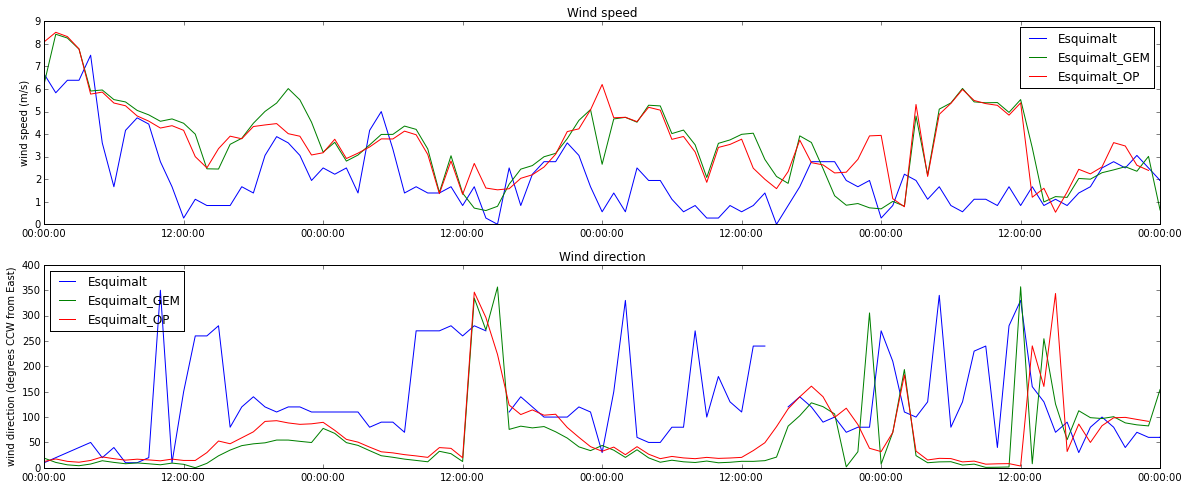

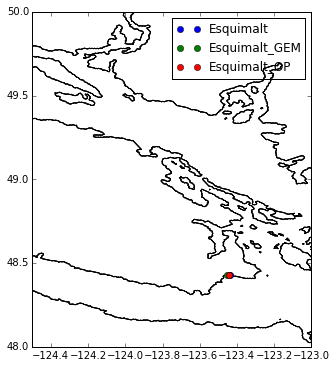

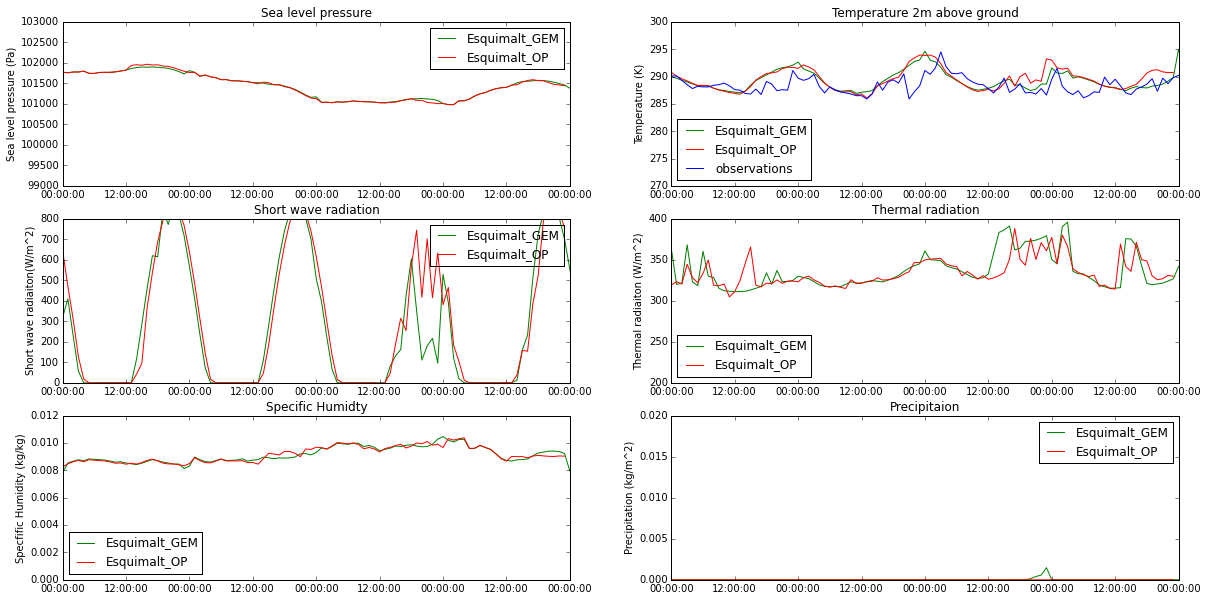

In [21]:
ax=compare_winds('Esquimalt','Esquimalt_GEM','Esquimalt_OP',sax,eax)
ax.set_xlim([-124.5,-123])
ax.set_ylim([48,50])
ax =compare_other_fields('Esquimalt_GEM','Esquimalt_OP',sax,eax)

## Aberdeen Buoy

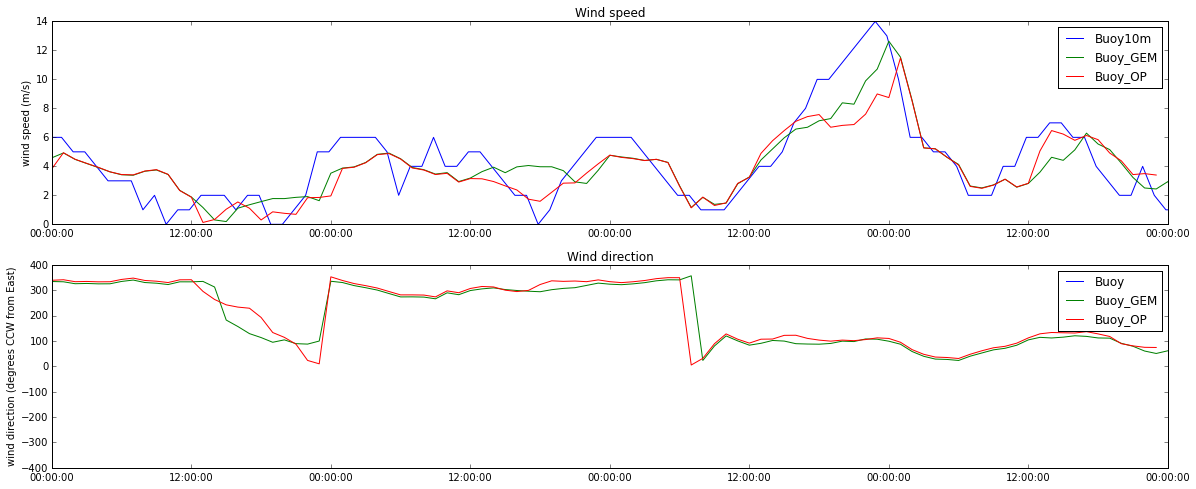

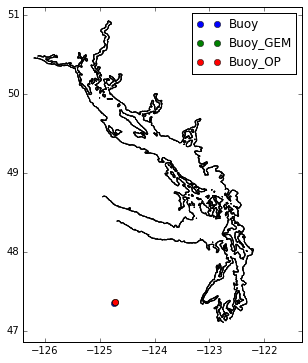

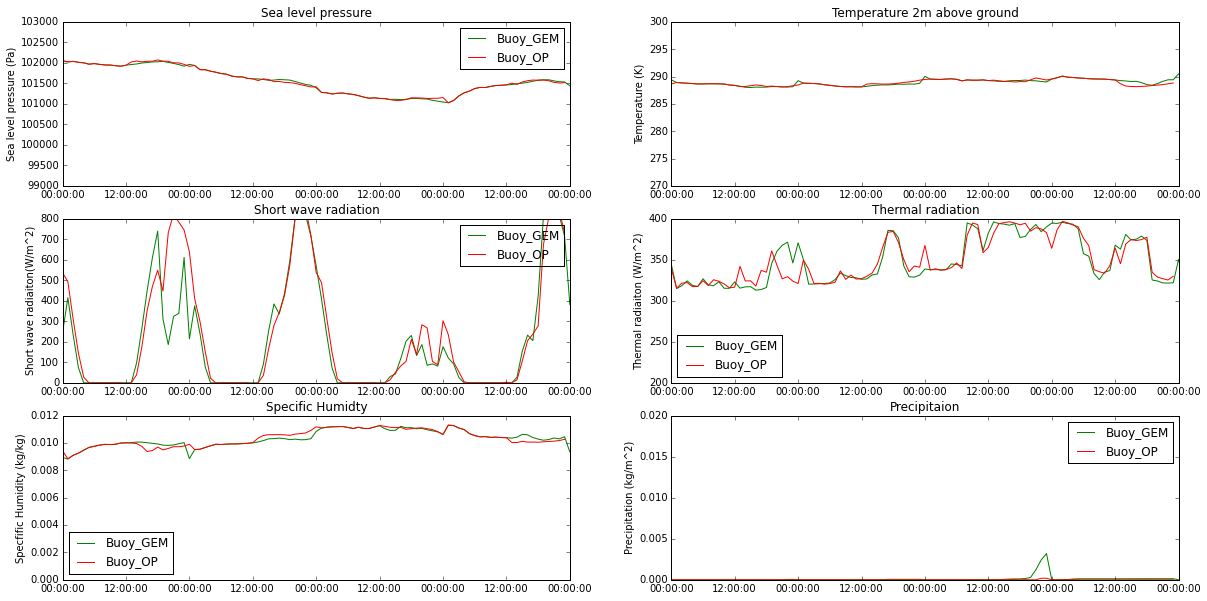

In [22]:
fig,axs = plt.subplots(2,1,figsize=(20,8))

for key in ['Buoy10m','Buoy_GEM', 'Buoy_OP']:
    ax=axs[0]
    ax.plot(time[key],wind_speed[key],label=key)
    ax.set_title('Wind speed')
    ax.set_xlim(sax,eax)
    ax.legend(loc=0)
    ax.set_ylabel('wind speed (m/s)')
    
for key in ['Buoy','Buoy_GEM','Buoy_OP']:
    ax=axs[1]
    ax.plot(time[key],wind_dir[key],label=key)
    ax.set_title('Wind direction')
    ax.set_xlim(sax,eax)
    ax.legend(loc=0)
    ax.set_ylabel('wind direction (degrees CCW from East)')
    
fig,ax = plt.subplots(1,1,figsize=(5,6))
for key in ['Buoy','Buoy_GEM','Buoy_OP']:
    ax.plot(lon[key],lat[key],'o',label=key)
    viz_tools.plot_coastline(ax,grid,coords='map')
    ax.legend(loc=0)
    
ax =compare_other_fields('Buoy_GEM','Buoy_OP',sax,eax)